# 17 - Bag of Visual Words

Neste roteiro iremos explorar o método Bag of Visual Words para a determinação de similaridade entre imagens. Apesar de existirem métodos prontos no OpenCV iremos implementar partes deste método nós mesmos para fixar melhor os conceitos. 

**Aviso**: Ao pesquisar sobre este modelo a maioria dos recursos será sobre classificação de imagens, mas ele também é adequado para similaridade de imagens. 

O OpenCV já possui uma implementação de *Bag of Visual Words* fácil de usar, mas ela esconde detalhes demais do funcionamento do método. Como nosso objetivo é exercitar os conceitos por trás do modelo, criaremos nossa própria versão a partir de funções auxiliares disponibilizadas pelo OpenCV e scikit-learn. No projeto você pode (deve?) usar as funções do OpenCV diretamente. 

Nosso roteiro é dividido em duas grandes etapas. A primeira etapa, feita nas partes $0-4$ é o **treinamento** do nosso modelo. É nesta etapa que selecionamos um conjunto de imagens para criar nosso vocabulário e que determinamos quantos padrões visuais colocaremos no histograma. Isto é feito com base em um algoritmo de *agrupamento*, que encontre conjuntos de padrões visuais similares. Note que não existe um gabarito que defina qual deve ser a similaridade entre as imagens nem qual o resultado de uma busca. Por isso dizemos que este tipo de modelo é **não-supervisionado**, ou seja, toda informação usada está presente nas próprias imagens. O **treinamento** pode ser um processo lento pois, idealmente, ele é feito somente uma vez. Voltaremos nesse assunto na próxima semana, então você pode prosseguir mesmo que esta explicação não esteja 100% clara. 


A segunda etapa é a **aplicação** do modelo treinado para computar similaridades entre imagens. Nesta etapa computamos a representação em histograma de padrões visuais de uma imagem de busca e fazemos a comparação com as imagens do nosso banco de dados. Esta etapa deve ser muito rápida, pois o usuário espera uma resposta rápida de sistemas de busca.

# Parte 0 - Instalação do OpenCV e banco de imagens

Os trabalhos usando o *Bag of Words* costumam usar os métodos *SIFT* ou *SURF* para extração e descrição de pontos de interesse. Estes métodos são patenteados e para usá-los é necessário  instalar o pacote *opencv-contrib-python*, disponível via *pip*. Por alguma razão a versão mais atual não contém estes métodos, então precisamos instalar uma versão específica ligeiramente mais antiga. 

**Atenção**: é necessário desinstalar seu opencv antigo antes de instalar este pacote!

    > pip install opencv-contrib-python==3.4.0.12

Hoje iremos trabalhar com as funções usadas na atividade passsada. Vamos usar também o conjunto de imagens *Caltech101*, disponíveis [aqui](http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download). 

# Parte 1 - revisão

**Exercício**: crie uma função `def computa_descritores(img)` que recebe uma imagem e devolve os descritores dela. Você deve usar o método `SURF` neste exercício e, como na atividade anterior, pode ignorar as posições de cada ponto de interesse encontrado.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from sklearn.cluster import KMeans

In [2]:
CLUSTERS = 300

In [3]:
def computa_descritores(img):
    return cv.xfeatures2d.SURF_create().detectAndCompute(img,None)[1]

In [4]:
img = cv.imread("../aula_16/cachorro.jpg", 1)

In [5]:
desc1 = computa_descritores(img)

In [6]:
print(desc1)

[[ 0.00416395 -0.00560383  0.00440942 ...  0.00228015  0.00548687
   0.00461813]
 [ 0.00187166 -0.00320674  0.00244353 ...  0.0017552   0.00554898
   0.00406633]
 [-0.00716413  0.00019966  0.00983065 ...  0.00073274  0.00504225
   0.00260495]
 ...
 [-0.00166989  0.00680009  0.00325468 ... -0.00117845  0.00152024
   0.00237064]
 [-0.03082504 -0.0192249   0.03108295 ... -0.00209194  0.00102872
   0.00261453]
 [ 0.00693984 -0.00053958  0.01014346 ...  0.00047216  0.00550294
   0.00561132]]


**Exercício**: crie uma função `def le_descritores_imagens(pastas, max_items=5)` que recebe uma lista de pastas como argumento, computa os descritores de cada imagem dentro desta pasta e retorna uma tupla contendo uma lista com o caminho todas as imagens analisadas e uma matriz contendo seus descritores. Verifique que a matriz retornada é uma matriz do `numpy` e não uma lista de listas. Para tornar nosso processamento mais rápido, processe somente as 5 primeiras imagens de cada pasta. 

**Dica**: se não souber como listar os arquivos de um diretório em Python busque pela função `os.listdir`.

In [7]:
def le_descritores_imagens(pastas, max_itens=5):
    files_desc = []
    
    for pasta in pastas:
        files = os.listdir(pasta)[:max_itens if max_itens < len(os.listdir(pasta)) else len(os.listdir(pasta))]
        
        for filename in files:
            path = pasta + filename
            img = cv.imread(path, 1)
            desc = computa_descritores(img)
            files_desc.append((path, desc))
    
    return files_desc

A base de dados *Caltech101* está organizada em várias subpastas, cada uma contendo objetos de uma categoria específica. Vamos trabalhar inicialmente com as pastas `["faces", "garfield", "platypus", "nautilus", "elephant", "gerenuk"]`. Chame sua função para estas pastas e guarde os resultados obtidos. 

In [8]:
pastas = ["./vocab/faces/", "./vocab/garfield/", "./vocab/platypus/", "./vocab/nautilus/", "./vocab/elephant/", "./vocab/gerenuk/"]

In [9]:
img_info = le_descritores_imagens(pastas)

# Parte 2 - Criação do vocabulário e histograma

A criação do vocabulário de padrões visuais é feita usando um algoritmo de *clustering*. Este algoritmo identifica agrupamentos de padrões visuais e retorna, para cada agrupamento, um padrão representante (chamado de centróide por ele ser a média de todos os padrões do agrupamento). Grosso modo, cada centróide representa um conjunto de padrões muito similares, logo poderíamos substituí-los pelo centróide.

A biblioteca *scikit-learn* já possui uma implementação do algoritmo *KMeans* que pode ser usada para identificar estes padrões. Veja [neste link](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) a documentação e um exemplo de uso.

Nesta parte do roteiro iremos executar a segunda parte do algoritmo: iremos criar o vocabulário e uma função que cria o histograma de padrões visuais.

**Exercício**: crie uma função `def cria_vocabulario(descritores, sz=300)` que aplica o algoritmo acima e devolve uma tupla contendo a matriz com cada centróide em uma linha e o objeto `KMeans` criado. Note que a matriz deverá ter `sz` linhas (valor padrão 300) e o mesmo número de colunas dos descritores computados na parte anterior. Você deverá chamar esta função com a matriz de descritores criada na parte anterior.

Chamaremos esta tupla nas próximas funções de vocabulário.

In [10]:
def cria_vocabulario(descritores, sz=300):
    kmeans = KMeans(n_clusters=sz, random_state=0)
    kmeans.fit(descritores)
    
    return kmeans.cluster_centers_, kmeans, 

In [11]:
all_desc = img_info[0][1]
for i in range(1, len(img_info)):
    all_desc = np.append(all_desc, img_info[i][1], 0)

In [12]:
all_desc.shape

(24665, 64)

In [13]:
centroides, kmeans_obj = cria_vocabulario(all_desc, CLUSTERS) #perguntar pro igor

C:\Users\lucas\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [15]:
print(centroides[0])

[ 1.60975126e-03 -3.25240311e-04  4.52938210e-03  2.85575469e-03
  3.30254212e-02 -8.97377380e-04  4.83594835e-02  2.45906319e-02
  1.96068417e-02  5.06835803e-03  4.04021405e-02  3.23454477e-02
  9.58408054e-06  1.22232188e-04  5.91223640e-03  4.47638938e-03
  7.73738977e-03 -2.94838590e-03  2.86009535e-02  1.63191557e-02
  3.78390133e-01  3.97628210e-02  4.31519508e-01  1.24468252e-01
  5.62871061e-02  1.07412539e-01  1.95400879e-01  1.99000090e-01
  7.12822890e-04  8.24357197e-03  3.81896608e-02  3.22427265e-02
  9.10642836e-03 -8.31061509e-04  2.63205580e-02  1.58449449e-02
  3.86694878e-01 -3.73922661e-02  4.31748509e-01  1.19953156e-01
  1.51168153e-01  4.56882082e-03  2.48461545e-01  1.76530614e-01
 -3.77847045e-03  1.25283869e-02  3.31274718e-02  3.32505703e-02
  1.76877959e-03  3.96164221e-04  3.60633084e-03  2.22730264e-03
  3.86608243e-02 -5.14258910e-03  4.84585091e-02  2.13610493e-02
  3.44835632e-02 -1.88413933e-02  4.62566726e-02  3.75559777e-02
  7.36739603e-04 -1.18939

**Exercício**: crie uma função `def representa_histograma(img, vocab)` que recebe uma imagem e um vocabulário e devolve um histograma que a represente. Se você estiver em dúvida como isto deve ser feito, consulte os slides desta aula.

**Dica**: o objeto `KMeans` criado na função anterior já possui uma função que calcula as distâncias até cada centróide. Consulte [sua documentação](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.transform) para entender como usá-la. 

In [341]:
def representa_histograma(img, kmeans):
    class_freq = {}
    desc = computa_descritores(img)
    pred_list = kmeans.predict(desc)
    for predicted in pred_list:
        if predicted not in class_freq.keys():
            class_freq[predicted] = 1
        else:
            class_freq[predicted] += 1
    
    freq_list = []
    for i in range(CLUSTERS):
        if i not in class_freq.keys():
            freq_list.append([0])
        else:
            freq_list.append([class_freq[i]])
    
    return class_freq, np.array(freq_list).astype(np.float32)

Teste sua função com alguma das imagens do *Caltech101*. 

In [342]:
test_img = cv.imread("faces.jpg", 1)
class_freq = representa_histograma(test_img, kmeans_obj)

<BarContainer object of 195 artists>

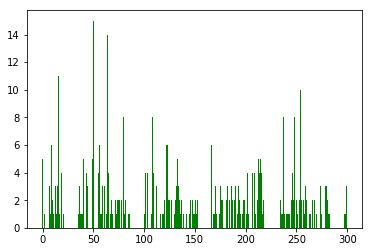

In [343]:
plt.bar(class_freq[0].keys(), class_freq[0].values(), color='g')

In [344]:
test_img2 = cv.imread("./vocab/faces/image_0010.jpg", 1)
class_freq2 = representa_histograma(test_img2, kmeans_obj)

<BarContainer object of 204 artists>

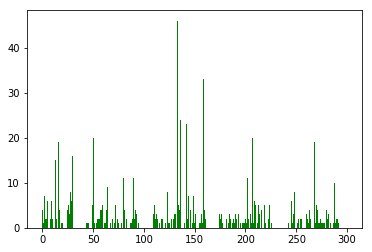

In [345]:
plt.bar(class_freq2[0].keys(), class_freq2[0].values(), color='g')

In [346]:
dist = cv.compareHist(class_freq[1], class_freq2[1], cv.HISTCMP_CHISQR)

In [347]:
print(dist)

2390.9205627705633


# Parte 3 - Similaridade entre imagens

Na última parte criamos uma função que representa uma imagem como um histograma de padrões visuais. Agora nos resta comparar duas imagens e criar um ranqueamento de quais imagens do banco de dados são mais parecidas com uma imagem de busca.

**Exercício**: Um método comum para comparação de histogramas é a utilização da distância $\chi^2$. Escreva abaixo sua fórmula e interprete-a.

A formula de  $\chi^2$ é representada pela seguinte equação:

\begin{equation*}
\left( \sum_{i=1}^n (x_i - y_i)^2/x_i + y_i \right)
\end{equation*}

Aonde xi, yi representam a frequencia de cada classe i para seus respectivos histogramas.

**Exercício**: o OpenCV já possui uma função de comparação de histogramas. Qual é ela? Como usá-la para computar a distância $\chi^2$.

#### R:
Função:
cv2.compareHist(h1, h2, metrica) aonde metrica eh CV_COMP_CHISQR para $\chi^2$

# Parte 4 - juntando tudo

Vamos agora juntar todas as partes criadas anteriormente na versão $0.5$ de nosso buscador. Para cada pasta processada na parte 1, 

1. escolha uma imagem que não foi usada na determinação do vocabulário
2. compute a distância dela para todas as imagens do vocabulário
3. Mostre as três imagens com menor distância.

Note que os passos acima incluem representar cada imagem do vocabulário como um histograma. Tome cuidado para não fazer isto mais de uma vez. 

Faça seu código de maneira modular, de maneira que para realizar a busca você apenas chame uma função. Você pode supor que esta função recebe como entrada qualquer objeto retornado pelas funções das etapas anteriores. 

**Exercício**: mostre, visualmente, os resultados de três buscas feitas com seu trabalho e comente os resultados

In [348]:
VOCAB_DIR = "./vocab/"
all_files = []
for pasta in pastas:
    files = os.listdir(pasta)
    for filename in files:
        all_files.append(pasta+filename)

print(len(all_files))

650


In [349]:
def busca(img, database, kmeans, max_results=3):
    img_freq = representa_histograma(img, kmeans)[1]
    
    results = []
    for filename in database:
        db_img = cv.imread(filename, 1)
        db_img_freq = representa_histograma(db_img, kmeans)[1]
        
        dist = cv.compareHist(img_freq, db_img_freq, cv.HISTCMP_CHISQR)
        
        results.append((filename, dist))
    
    
    return sorted(results, key=lambda x: x[1])[:max_results]
    
    

In [350]:
test_img = cv.imread("faces.jpg", 1)
res = busca(test_img, all_files, kmeans_obj)

### IMAGEM DE FACE BUSCADA

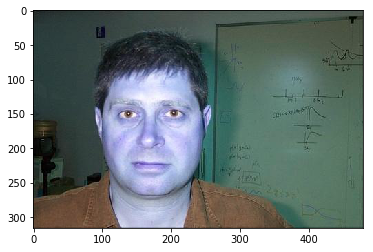

In [351]:
plt.imshow(test_img)

### RESULTADOS

349.08127705627703


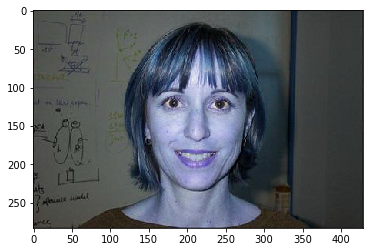

In [352]:
plt.imshow(cv.imread(res[0][0], 1))
print(res[0][1])

354.46461038961036


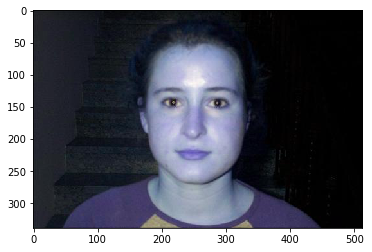

In [353]:
plt.imshow(cv.imread(res[1][0], 1))
print(res[1][1])

387.90746753246754


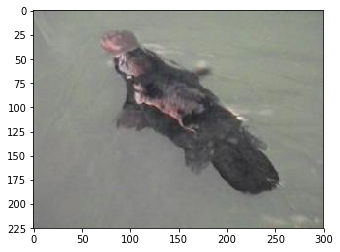

In [354]:
plt.imshow(cv.imread(res[2][0], 1))
print(res[2][1])

### IMAGEM DE GARFIELD BUSCADA

In [355]:
test_img = cv.imread("garfield.jpg", 1)
res = busca(test_img, all_files, kmeans_obj)

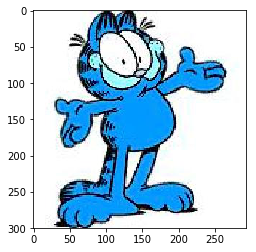

In [356]:
plt.imshow(test_img)

### RESULTADOS

175.28744401839995


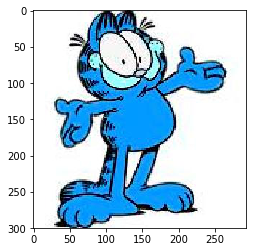

In [357]:
plt.imshow(cv.imread(res[0][0], 1))
print(res[0][1])

190.8932683683419


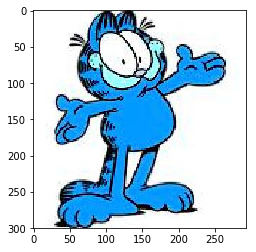

In [358]:
plt.imshow(cv.imread(res[1][0], 1))
print(res[1][1])

211.82854073486422


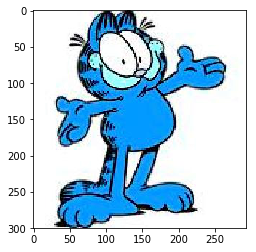

In [359]:
plt.imshow(cv.imread(res[2][0], 1))
print(res[2][1])

In [309]:
print(res)

[('./vocab/garfield/image_0032.jpg', 80.08021512599235), ('./vocab/garfield/image_0034.jpg', 96.38615848820508), ('./vocab/garfield/image_0033.jpg', 96.58997703023904)]


### IMAGEM DE NAUTILUS BUSCADA

In [360]:
test_img = cv.imread("nautilus.jpg", 1)
res = busca(test_img, all_files, kmeans_obj)

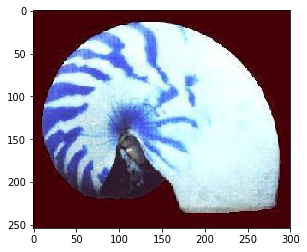

In [361]:
plt.imshow(test_img)

### RESULTADO

247.98606562519606


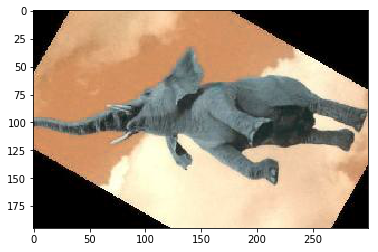

In [362]:
plt.imshow(cv.imread(res[0][0], 1))
print(res[0][1])

290.56046176046175


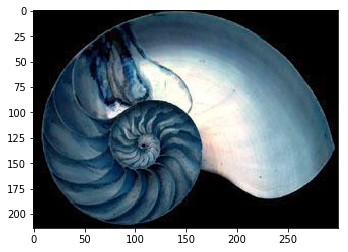

In [363]:
plt.imshow(cv.imread(res[1][0], 1))
print(res[1][1])

296.62024100812926


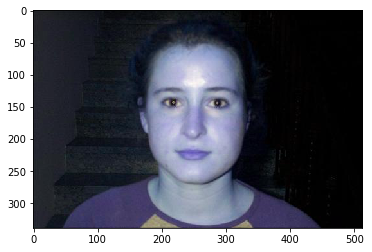

In [364]:
plt.imshow(cv.imread(res[2][0], 1))
print(res[2][1])

### IMAGEM DE ELEPHANT BUSCADA

In [365]:
test_img = cv.imread("elephant.jpg", 1)
res = busca(test_img, all_files, kmeans_obj)

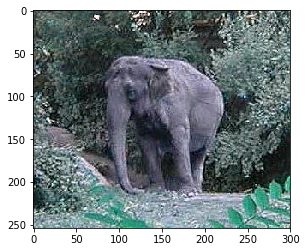

In [366]:
plt.imshow(test_img)

### RESULTADO

485.1570039863515


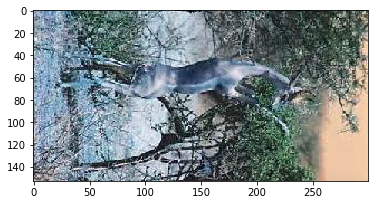

In [367]:
plt.imshow(cv.imread(res[0][0], 1))
print(res[0][1])

486.99878002432337


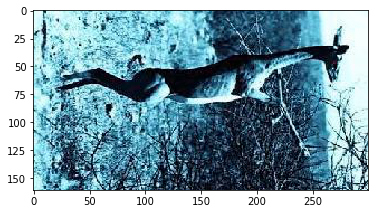

In [368]:
plt.imshow(cv.imread(res[1][0], 1))
print(res[1][1])

493.6198776465081


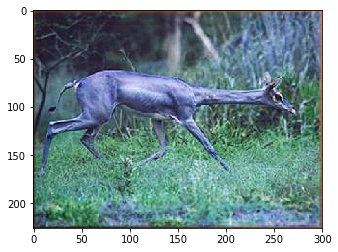

In [369]:
plt.imshow(cv.imread(res[2][0], 1))
print(res[2][1])

### IMAGEM DE GERENUK BUSCADA

In [370]:
test_img = cv.imread("gerenuk.jpg", 1)
res = busca(test_img, all_files, kmeans_obj)

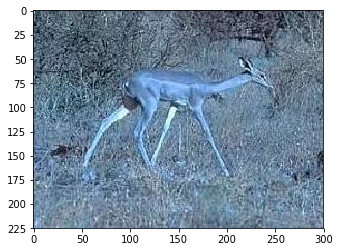

In [371]:
plt.imshow(test_img)

### RESULTADO

480.4561351842874


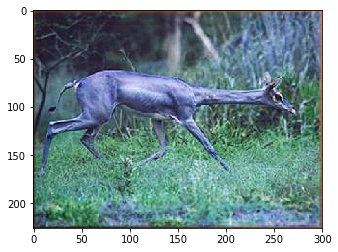

In [372]:
plt.imshow(cv.imread(res[0][0], 1))
print(res[0][1])

520.6483991172561


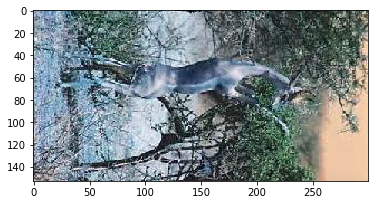

In [373]:
plt.imshow(cv.imread(res[1][0], 1))
print(res[1][1])

550.0795428484777


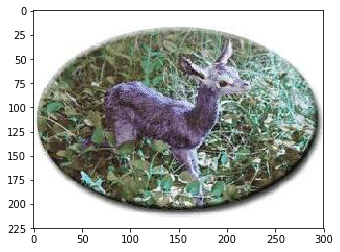

In [374]:
plt.imshow(cv.imread(res[2][0], 1))
print(res[2][1])

*Comente seus resultados aqui*

Aparentemente alguns resultados não foram tão bons quanto o desejado. Aumentar o numero de centroides (inicialmente era de 50, depois 100 e depois 300) pareceu aliviar um pouco o problema, com custo de velocidade de treinamento do clustering.
